# Training and Evaluating a POS Tagger

In [1]:
%load_ext autoreload
%autoreload 2

In [434]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re

import spacy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models.keyedvectors import load_word2vec_format
from gensim.models import Word2Vec, KeyedVectors

import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, confusion_matrix

from training import get_embedding_weights, POSDataset, Model, train_eval
from preprocessing import split_text_into_lines, extract_text_and_target, encode_text
from analysis import plot_learning_curve, inference_with_metrics, get_analysis_dataframe

## Preprocessing

### Create dataframe

In [4]:
with open('train.txt') as f:
    train_data = f.readlines()
with open('test.txt') as f:
    test_data = f.readlines()

In [11]:
train_lines = split_text_into_lines(train_data)
test_lines = split_text_into_lines(test_data)

In [14]:
train_text, train_targets = extract_text_and_target(train_lines)
test_text, test_targets = extract_text_and_target(test_lines)

In [21]:
train_df = pd.DataFrame(data={"text": train_text, "target": train_targets, "stage": ["train" for x in train_text]})
test_df = pd.DataFrame(data={"text": test_text, "target": test_targets, "stage": ["test" for x in test_text]})

In [22]:
df = pd.concat([train_df, test_df], axis=0)

In [23]:
df.head()

,text,target,stage
0,"[Confidence, in, the, pound, is, widely, expec...","[NN, IN, DT, NN, VBZ, RB, VBN, TO, VB, DT, JJ,...",train
1,"[Chancellor, of, the, Exchequer, Nigel, Lawson...","[NNP, IN, DT, NNP, NNP, NNP, POS, VBN, NN, TO,...",train
2,"[But, analysts, reckon, underlying, support, f...","[CC, NNS, VBP, VBG, NN, IN, NN, VBZ, VBN, VBN,...",train
3,"[This, has, increased, the, risk, of, the, gov...","[DT, VBZ, VBN, DT, NN, IN, DT, NN, VBG, VBN, T...",train
4,"[``, The, risks, for, sterling, of, a, bad, tr...","[``, DT, NNS, IN, NN, IN, DT, JJ, NN, NN, VBP,...",train


In [212]:
# check if length of X and Y are the same for each sample
for idx, row in df.iterrows():
    if len(row["text"]) != len(row["target"]):
        print(idx)

### EDA

In [218]:
print(
    f"Total number of sentences:\n" 
    f"Training set {len(train_df)}\n"
    f"Test set {len(test_df)}"
)

Total number of sentences:
Training set 8044
Test set 2013


In [334]:
avg_train_sent_length = np.mean([len(row["text"]) for _, row in train_df.iterrows()])
avg_test_sent_length = np.mean([len(row["text"]) for _, row in test_df.iterrows()])
    
print(
    f"Avg. number of words per sentence:\n"
    f"Training set: {avg_train_sent_length:.1f}\n"
    f"Test set: {avg_test_sent_length:.1f}"
)

Avg. number of words per sentence:
Training set: 23.7
Test set: 23.5


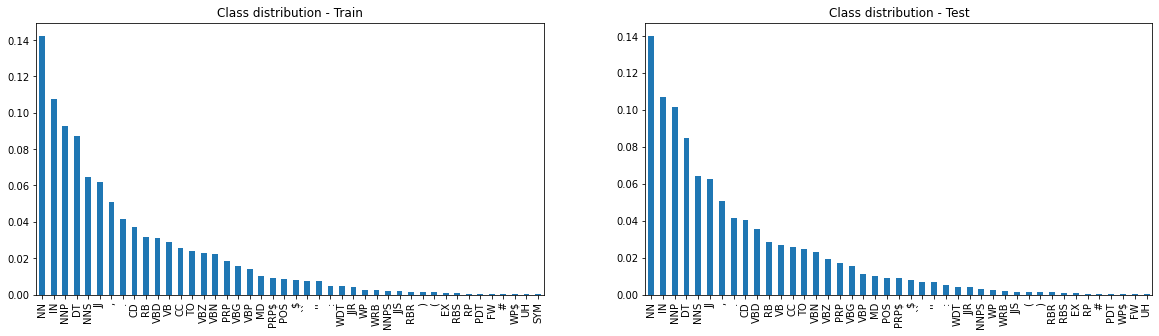

In [246]:
plt.figure(figsize=(20,5))

for plot, (string, df) in enumerate(zip(["Train", "Test"], [train_df, test_df])):
    
    pos_tags = list()
    for idx, row in df.iterrows():
        pos_tags.extend(row["target"])

    plt.subplot(1, 2, plot+1)
    pd.Series(pos_tags).value_counts(normalize=True).plot.bar()
    plt.title(f"Class distribution - {string}")
    
plt.show()

### Targets

In [25]:
# get all unique POS tags

unique_pos_tags = set()
for idx, row in df.iterrows():
    for tag in row["target"]:
        if tag not in unique_pos_tags:
            unique_pos_tags.add(tag)

print(unique_pos_tags)

{'CC', '.', 'VBD', 'JJS', 'VB', 'FW', ':', 'IN', 'VBG', 'WRB', 'POS', ',', 'NNS', 'RBR', 'WP', 'PDT', 'JJ', 'UH', 'NNPS', 'TO', '``', 'RBS', 'WDT', '#', '$', 'RB', 'JJR', 'NNP', 'MD', 'NN', 'VBN', 'VBP', 'PRP$', '(', "''", 'EX', 'WP$', 'CD', 'DT', 'RP', ')', 'PRP', 'VBZ', 'SYM'}


In [26]:
# create numerical encodings for POS tags

pos2value = dict()
pos2value[0] = 0
for idx, tag in enumerate(unique_pos_tags):
    pos2value[tag] = idx + 1  # because 0 will be padding token in both text and target

value2pos = {v: k for k, v in pos2value.items()}

print(pos2value)

{0: 0, 'CC': 1, '.': 2, 'VBD': 3, 'JJS': 4, 'VB': 5, 'FW': 6, ':': 7, 'IN': 8, 'VBG': 9, 'WRB': 10, 'POS': 11, ',': 12, 'NNS': 13, 'RBR': 14, 'WP': 15, 'PDT': 16, 'JJ': 17, 'UH': 18, 'NNPS': 19, 'TO': 20, '``': 21, 'RBS': 22, 'WDT': 23, '#': 24, '$': 25, 'RB': 26, 'JJR': 27, 'NNP': 28, 'MD': 29, 'NN': 30, 'VBN': 31, 'VBP': 32, 'PRP$': 33, '(': 34, "''": 35, 'EX': 36, 'WP$': 37, 'CD': 38, 'DT': 39, 'RP': 40, ')': 41, 'PRP': 42, 'VBZ': 43, 'SYM': 44}


In [31]:
# encode targets in train and test set

targets_encoded = list()
for idx, row in df.iterrows():
    target_encoded = list()
    for tag in row["target"]:
        target_encoded.append(pos2value[tag])
    targets_encoded.append(target_encoded)

In [247]:
# get max sentence lengths sentence_lengths = [len(row["text"]) for idx, row in train_df.iterrows()]
max_seq_length = max(sentence_lengths)
print("Median sentence length", np.median(sentence_lengths))
print("Max sentence length", max_seq_length)

Median sentence length 23.0
Max sentence length 78


In [33]:
# pad targets to max sentence length

targets_padded = pad_sequences(targets_encoded, maxlen=max_seq_length, padding='post')
targets_padded = [target.tolist() for target in targets_padded]

In [34]:
print(len(targets_encoded[0]))
print(len(targets_padded[0]))

37
78


In [35]:
df["target_encoded"] = targets_encoded
df["target_padded"] = targets_padded

### Inputs

#### 1 - Tokenizing + Vocabulary Keras

In [435]:
# encode text

tokenizer = Tokenizer(filters="")
text_encoded, word2value = encode_text(df["text"], tokenizer)

In [42]:
# pad text

texts_padded = pad_sequences(text_encoded, maxlen=max_seq_length, padding='post')
texts_padded = [text.tolist() for text in texts_padded]

In [43]:
df["text_encoded"] = text_encoded
df["text_padded"] = texts_padded

In [44]:
print(len(text_encoded[0]))
print(len(texts_padded[0]))

37
78


In [45]:
# check if padded text and padded targets have the same length

for idx in range(len(df)):
    if len(df["text_padded"].iloc[idx]) != len(df["target_padded"].iloc[idx]):
        print(idx)

In [48]:
df.sample(3)

,text,target,stage,target_encoded,target_padded,text_encoded,text_padded
1875,"[Fears, that, Ford, 's, ardor, might, be, cool...","[NNS, IN, NNP, POS, NN, MD, VB, NN, NN, NNP, N...",test,"[13, 8, 28, 11, 30, 29, 5, 30, 30, 28, 13, 8, ...","[13, 8, 28, 11, 30, 29, 5, 30, 30, 28, 13, 8, ...","[1437, 11, 601, 10, 19349, 300, 28, 19350, 352...","[1437, 11, 601, 10, 19349, 300, 28, 19350, 352..."
2748,"[Fear, is, the, father, of, panic, .]","[NN, VBZ, DT, NN, IN, NN, .]",train,"[30, 43, 39, 30, 8, 30, 2]","[30, 43, 39, 30, 8, 30, 2, 0, 0, 0, 0, 0, 0, 0...","[1066, 15, 2, 2161, 4, 3140, 3]","[1066, 15, 2, 2161, 4, 3140, 3, 0, 0, 0, 0, 0,..."
3536,"[Rick, Sherlund, ,, a, Goldman, Sachs, analyst...","[NNP, NNP, ,, DT, NNP, NNP, NN, ,, VBZ, VBN, P...",train,"[28, 28, 12, 39, 28, 28, 30, 12, 43, 31, 33, 1...","[28, 28, 12, 39, 28, 28, 30, 12, 43, 31, 33, 1...","[8590, 6616, 1, 6, 2073, 2357, 366, 1, 35, 116...","[8590, 6616, 1, 6, 2073, 2357, 366, 1, 35, 116..."


In [ ]:
df["text_lower"] = text

In [ ]:
# create vocabulary based on unique words and IDs

unique_words = set()
for idx in range(len(df)):
    for word in df["text"].iloc[idx]:
        if word.lower() not in unique_words:
            unique_words.add(word.lower())

print(len(unique_tokens))

word2value = dict()
for idx, word in enumerate(unique_words):
    word2value[word] = idx

17258


In [ ]:
texts_encoded = list()
for idx in range(len(df)):
    text_encoded = list()
    for word in df["text"].iloc[idx]:
        text_encoded.append(word2value[word.lower()])
    texts_encoded.append(text_encoded)

In [ ]:
df["text_encoded"] = texts_encoded

#### Word Embeddings

In [49]:
word2vec = load_word2vec_format("/home/hkortschak/Repositories/commonlit_kaggle/xund/GoogleNews-vectors-negative300.bin", binary=True)

In [450]:
embedding_weights = get_embedding_weights(300, word2value, word2vec)

1545 words not in Word2Vec - initializing their weights with 0.


### Split dataset

In [53]:
# randomly split train data into training and validation set

train_df = df[df["stage"] == "train"]
test_df = df[df["stage"] == "test"]

train_df = train_df.sample(frac=1, random_state=0).reset_index(drop=True)
num_train_samples = int(len(train_df) * 0.9) + 1
num_valid_samples = int(len(train_df) * 0.1)
print(num_train_samples, num_valid_samples)

8044 893


In [54]:
train_df = df[:num_train_samples].reset_index()
valid_df = df[num_train_samples:].reset_index()

In [146]:
train_X = train_df["text_padded"]
train_Y = train_df["target_padded"]

valid_X = valid_df["text_padded"]
valid_Y = valid_df["target_padded"]

test_X = test_df["text_padded"]
test_Y = test_df["target_padded"]

### Data Loader

In [445]:
# dataset

train_ds = POSDataset(train_X, train_Y) 
valid_ds = POSDataset(valid_X, valid_Y) 
test_ds = POSDataset(test_X, test_Y) 

In [446]:
# data loader

train_dl = DataLoader(train_ds, batch_size=36)
valid_dl = DataLoader(valid_ds, batch_size=36, shuffle=False)

In [558]:
print(train_df["text"].iloc[1])
input_ = train_df["text_padded"].iloc[1] # (max_seq_length)
input_ = torch.tensor(input_, dtype=torch.long).unsqueeze(0)
print(input_.shape)
print(input_.dtype)

['The', 'promotions', '--', 'dubbed', 'everything', 'from', "'T-", 'is', 'the', 'Season', 'to', 'be', 'Jolly', 'to', 'Kringle', 'fares', '--', 'put', 'round-trip', 'fares', 'at', '$', '98', ',', '$', '148', 'and', '$', '198', '.']
torch.Size([1, 78])
torch.int64


In [483]:
output = model(input_)

Input torch.Size([1, 78])
Embedding torch.Size([1, 78, 300])
RNN Output torch.Size([1, 78, 64])
TDD Input torch.Size([1, 1, 78, 64])
TDD Output torch.Size([1, 45, 78, 1])
Return torch.Size([1, 45, 78])


In [484]:
cls_output = torch.argmax(output, dim=1).squeeze(0)
print(cls_output.shape)

torch.Size([78])


In [489]:
print(train_df["target_padded"].iloc[1])
print(cls_output)

[28, 29, 20, 28, 17, 17, 40, 43, 29, 7, 11, 40, 35, 41, 3, 41, 3, 43, 20, 23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tensor([42, 42, 37, 15, 15,  7, 15, 29, 37, 40, 42, 15, 17, 15, 40, 38, 40, 37,
        15, 15, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37])


In [515]:
classes = list(value2pos.keys())

target = np.array(train_df["target_encoded"].iloc[1])
pred = np.array(cls_output[:len(target)])

print(target)
print(pred)

f1 = f1_score(target, pred, labels=classes, average="micro")
print(f1)
#for cls in classes[1:]: # don't take adding class into account
#    target_cls = np.where(target == cls, target, 0)
#    pred_cls = np.where(pred == cls, pred, 0)
#    #print(target_cls)
#    #print(pred_cls)
#    f1 = f1_score(target_cls, pred_cls)
#    print(f1)
##f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', 

[28 29 20 28 17 17 40 43 29  7 11 40 35 41  3 41  3 43 20 23]
[42 42 37 15 15  7 15 29 37 40 42 15 17 15 40 38 40 37 15 15]
0.0


## Training Loop

In [447]:
class Model(nn.Module):
    def __init__(
            self,
            output_size,
            hidden_dim,
            n_layers,
            embedding_weights,
            embedding_size
    ):
        super(Model, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=False, padding_idx=0)
        self.rnn = nn.RNN(embedding_size, hidden_dim, n_layers)
        self.tdd = nn.Conv2d(1, output_size, (1, hidden_dim))

    def forward(self, x):  # (bs, sl)

        embedding = self.embedding(x)  # (bs, sl) --> (bs, sl, es)
        output, hidden = self.rnn(embedding)  # (bs, sl, es) --> (bs, sl, hd)
        output = output.unsqueeze(1)  # (bs, sl, hd) --> (bs, 1, sl, hd) (add channel dim)
        output = self.tdd(output)  # (bs, 1, sl, hd) (bs, ch, w, h) --> (bs, os, sl, 1) (bs, ch, w, h)
        output = output.squeeze(-1)  # (bs, os, sl) --> postprecessing: argmax(dim=1) --> (bs, sl)

        return output

In [419]:
# start training

train_losses, valid_losses = train_eval(
    train_dataloader=train_dl, 
    valid_dataloader=valid_dl, 
    model=model2,
    num_epochs=200,
    early_stopping=15,
    learning_rate=0.0001,
    weight_decay=1e-8,
    device=torch.device("cpu")
)

----- Epoch 1 ----- 
Avg. train loss 2.250
Avg. valid loss 1.606
----- Epoch 2 ----- 
Avg. train loss 1.585
Avg. valid loss 1.575
----- Epoch 3 ----- 
Avg. train loss 1.538
Avg. valid loss 1.496
----- Epoch 4 ----- 
Avg. train loss 1.402
Avg. valid loss 1.294
----- Epoch 5 ----- 
Avg. train loss 1.196
Avg. valid loss 1.150
----- Epoch 6 ----- 
Avg. train loss 1.053
Avg. valid loss 1.013
----- Epoch 7 ----- 
Avg. train loss 0.918
Avg. valid loss 0.909
----- Epoch 8 ----- 
Avg. train loss 0.812
Avg. valid loss 0.816
----- Epoch 9 ----- 
Avg. train loss 0.710
Avg. valid loss 0.741
----- Epoch 10 ----- 
Avg. train loss 0.621
Avg. valid loss 0.671
----- Epoch 11 ----- 
Avg. train loss 0.556
Avg. valid loss 0.595
----- Epoch 12 ----- 
Avg. train loss 0.428
Avg. valid loss 0.497
----- Epoch 13 ----- 
Avg. train loss 0.351
Avg. valid loss 0.466
----- Epoch 14 ----- 
Avg. train loss 0.295
Avg. valid loss 0.406
----- Epoch 15 ----- 
Avg. train loss 0.245
Avg. valid loss 0.398
----- Epoch 16 ----

In [326]:
# start training

train_losses, valid_losses = train_eval(
    train_dataloader=train_dl, 
    valid_dataloader=valid_dl, 
    model=model,
    num_epochs=200,
    early_stopping=15,
    learning_rate=0.0001,
    weight_decay=1e-8,
    device=torch.device("cpu")
)

----- Epoch 1 ----- 
Avg. train loss 2.630
Avg. valid loss 1.599
----- Epoch 2 ----- 
Avg. train loss 1.488
Avg. valid loss 1.275
----- Epoch 3 ----- 
Avg. train loss 1.077
Avg. valid loss 0.863
----- Epoch 4 ----- 
Avg. train loss 0.726
Avg. valid loss 0.594
----- Epoch 5 ----- 
Avg. train loss 0.479
Avg. valid loss 0.427
----- Epoch 6 ----- 
Avg. train loss 0.329
Avg. valid loss 0.334
----- Epoch 7 ----- 
Avg. train loss 0.242
Avg. valid loss 0.284
----- Epoch 8 ----- 
Avg. train loss 0.181
Avg. valid loss 0.248
----- Epoch 9 ----- 
Avg. train loss 0.149
Avg. valid loss 0.233
----- Epoch 10 ----- 
Avg. train loss 0.126
Avg. valid loss 0.218
----- Epoch 11 ----- 
Avg. train loss 0.111
Avg. valid loss 0.215
----- Epoch 12 ----- 
Avg. train loss 0.098
Avg. valid loss 0.205
----- Epoch 13 ----- 
Avg. train loss 0.089
Avg. valid loss 0.206
----- Epoch 14 ----- 
Avg. train loss 0.081
Avg. valid loss 0.200
----- Epoch 15 ----- 
Avg. train loss 0.074
Avg. valid loss 0.202
----- Epoch 16 ----

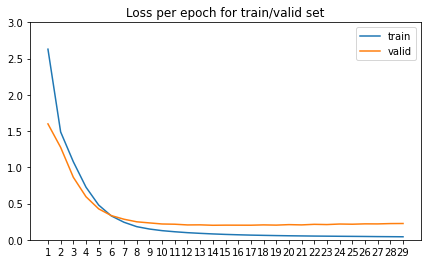

In [327]:
plot_learning_curve(train_losses, valid_losses)

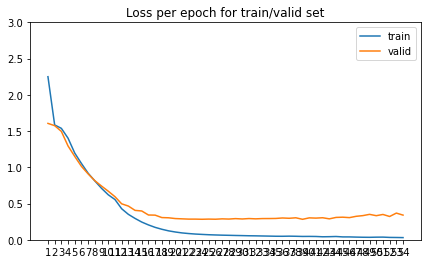

In [420]:
plot_learning_curve(train_losses, valid_losses)

## Analysis

In [421]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False)

In [425]:
# get top-1 accuracy for validation set
correct_valid, total_valid = inference_with_metrics(model, valid_dl, classes=list(value2pos.keys()))

In [426]:
# get top-1 accuracy for test set
correct_test, total_test = inference_with_metrics(model, test_dl, classes=list(value2pos.keys()))

In [427]:
print(
    f"Valid Top-1 Accuracy: {correct_valid['all'] / total_valid['all']:.4f}\n"
    f"Test Top-1 Accuracy: {correct_test['all'] / total_test['all']:.4f}"
)

Valid Top-1 Accuracy: 0.8793
Test Top-1 Accuracy: 0.8740


In [412]:
metrics_df = get_analysis_dataframe(value2pos, correct_valid, correct_test, total_valid, total_test)

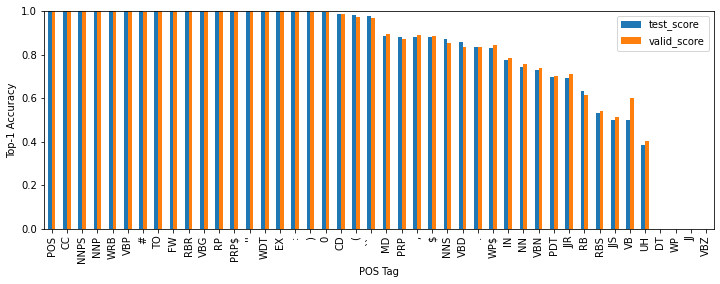

In [413]:
metrics_df.plot(
    x="tag", 
    y=["test_score", "valid_score"], 
    kind="bar", 
    ylim=(0,1), 
    figsize=(12, 4), 
    xlabel="POS Tag", 
    ylabel="Top-1 Accuracy"
);

In [456]:
metrics_df["test_samples_perc"] = metrics_df["test_samples"].div(metrics_df["test_samples"].sum(),axis=0)
metrics_df["valid_samples_perc"] = metrics_df["valid_samples"].div(metrics_df["valid_samples"].sum(),axis=0)

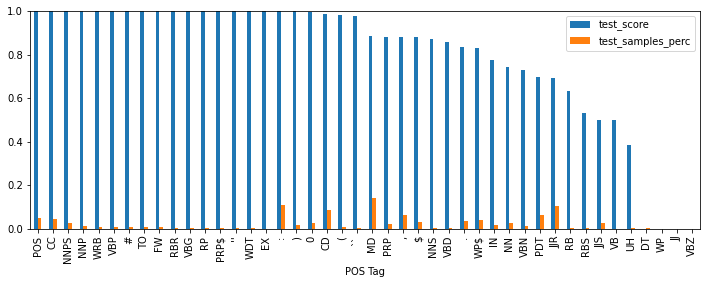

In [458]:
metrics_df.plot(
    x="tag", 
    y=["test_score", "test_samples_perc"], 
    kind="bar", 
    ylim=(0,1), 
    figsize=(12, 4), 
    xlabel="POS Tag"
);

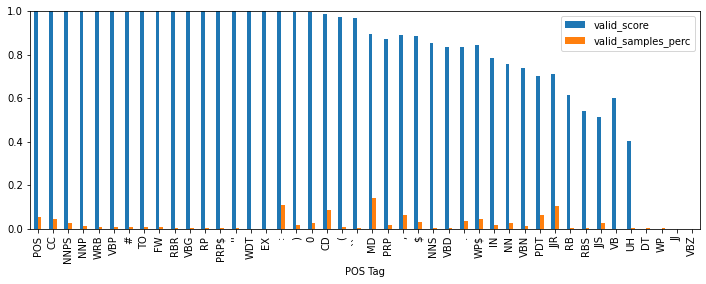

In [459]:
metrics_df.plot(
    x="tag", 
    y=["valid_score", "valid_samples_perc"], 
    kind="bar", 
    ylim=(0,1), 
    figsize=(12, 4), 
    xlabel="POS Tag"
);

In [457]:
metrics_df

,tag,test_score,valid_score,test_samples,valid_samples,test_samples_perc,valid_samples_perc
0,POS,1.000000,1.000000,2390,3474,0.050446,0.050830
1,CC,1.000000,1.000000,1975,2859,0.041687,0.041832
2,NNPS,1.000000,1.000000,1178,1704,0.024864,0.024932
3,NNP,1.000000,1.000000,470,667,0.009920,0.009759
4,WRB,1.000000,1.000000,434,614,0.009161,0.008984
5,VBP,1.000000,1.000000,421,594,0.008886,0.008691
6,#,1.000000,0.996546,384,579,0.008105,0.008472
7,TO,1.000000,1.000000,323,448,0.006818,0.006555
8,FW,1.000000,1.000000,238,348,0.005024,0.005092
9,RBR,1.000000,1.000000,110,150,0.002322,0.002195


In [415]:
metrics_df.sort_values(["test_samples"], ascending=False)

,tag,test_score,valid_score,test_samples,valid_samples
22,MD,0.886631,0.896405,6642,9624
16,:,0.999211,0.999179,5071,7308
34,JJR,0.690595,0.711821,4806,7013
19,CD,0.986318,0.986007,4020,5717
24,",",0.879697,0.889274,3034,4326
33,PDT,0.697031,0.702921,2964,4211
0,POS,1.000000,1.000000,2390,3474
1,CC,1.000000,1.000000,1975,2859
29,WP$,0.829510,0.843830,1918,3112
28,.,0.834425,0.833133,1679,2499
